# Load and Plot SWOT EXPERT LR Data at PIG

2km Level 2 Expert

In [1]:
%matplotlib widget
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from scipy.ndimage import generic_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from shapely.geometry import Polygon

In [2]:
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

In [3]:
# Functions to search and open Lansat scenes for SST
'''
From NLSST pipeline - update from there

Functions to search, open, and analyze Landsat scenes for SST.
Search_stac finds the Landsat scene based on user parameters, 
plot_search plots the locations of the landsat scenes from the search,
landsat_to_xarray takes one of those scenes and puts all bands into an xarray,
and create_masks produces cloud/ice/water masks for the scene. Subset_img 
subsets a landsat scene with coordinates that have been reprojected from lat/lon
and may be flipped in which is larger in the pair. Lsat_reproj can be used to reproject
while ensuring x and y pairs don't get flipped (common converting between espg 3031 and wgs84.
'''

def ls_thermal_to_xarray(sceneid, bandNames=None):
    """
    ***changed sceneid.id to sceneid***
    Function to ingest landsat scenes from AWS s3 bucket with alternate href.
    Args:
        catalog: an intake STAC item collection
        bandNames: a list of the bands you want e.g. ['red', 'swir16']
    Returns:
        Xarray of scenes with dimensions time, band, y, x
    """

    # Import to xarray with cloud mask
    # nans are in locations where concat of multiple scenes has expanded the grid
    item = catalog[sceneid.id]

    bands = []
    band_names = []

    if bandNames is None:
        # Get band names
        for k in item.keys():
            M = getattr(item, k).metadata
            if 'eo:bands' in M:
                resol = M['eo:bands'][0]['gsd']
                if resol >= 30: # thermal bands are up sampled from 100 to 30
                    band_names.append(k)
    else:
        band_names = bandNames

    # Add qa band
    if 'qa_pixel' not in band_names:
        band_names.append('qa_pixel')

    # Construct xarray for scene
    for band_name in band_names:
        asset = sceneid.assets[band_name]
        href = asset.extra_fields['alternate']['s3']['href']
        band = xr.open_dataset(href, engine='rasterio', chunks=dict(band=1, x=512, y=512))
        band['band'] = [band_name]
        bands.append(band)
    ls_scene = xr.concat(bands, dim='band')
    ls_scene.coords['id'] = sceneid.id
    ls_scene.coords['time'] = item.metadata['datetime'].strftime('%Y-%m-%dT%H:%M:%S')
    ls_scene = ls_scene['band_data']

    return ls_scene

##########################

def create_masks(ls_scene, cloud_mask=True, ice_mask=False, ocean_mask=False):
    """
    Create cloud, ice, and ocean masks. cloud is 1, ice is 2, ocean is 3, everything else is NaN.
    Args:
        ls_scene: xarray of one LS scenes output from landsat_to_xarray
        cloud_mask: bool to generate cloud mask, default True
        ice_mask: bool to generate ice mask, default False
        ocean_mask: bool to generate ocean mask, default False
    Returns:
        new xarray of LS scene with mask
    """
    
    cloud = []
    ocean = []
    ice = []

    qa = ls_scene.sel(band='qa_pixel').astype('uint16')

    n,c = np.unique(qa, return_counts=True)

    for j in range(len(n)):
        longform = f'{n[j]:016b}'
        if (longform[-7]=='0')|(longform[-3]=='1'): #bit 2 and 6 are for cirrus and clear sky
            cloud.append(n[j])
        if longform[-8:]=='11000000': #bit 6 and 7 give clear sky and water, lower bits need to be 0 
            ocean.append(n[j])
        if longform[-7:]=='1100000': #bit 5 and 6 give ice and clear sky 
            ice.append(n[j])

    if 0 in cloud:
        cloud.remove(0)
    if 1 in cloud:
        cloud.remove(1)

    # mask cloud, ice, and ocean
    if cloud_mask==True:
        # cloud is 2
        mask_c = xr.where(qa.isin(cloud), 1, np.nan)

    if ice_mask==True:
        mask_c = xr.where(qa.isin(ice), 2, mask_c)

    if ocean_mask==True:
        mask_c = xr.where(qa.isin(ocean), 3, mask_c)

    ls_scene.coords['mask'] = (('y', 'x'), mask_c.data)
        
    return ls_scene

##########################

def normalize(array):
    '''
    normalize a dask array so all value are between 0 and 1
    '''
    array_min = array.min(skipna=True)
    array_max = array.max(skipna=True)
    return (array - array_min) / (array_max - array_min)

##########################

def search_stac(url,bbox,timeRange,collection,gjson_outfile):
    # Search STAC API for Landsat images based on a bounding box, date and other metadata if desired
    api = pystac_client.Client.open(url)

    items = api.search(
                bbox = bbox,
                datetime = timeRange,
                # limit = 400,
                collections=collection
            ).item_collection()

    print(f'{len(items)} Landsat 8/9 items')

    # Write a json file that records our search output
    items.save_object(gjson_outfile)
    
    return items

##########################

def plot_search(gf,satellite,colnm):
    # Plot search AOI and frames on a map using Holoviz Libraries (more on these later)
    cols = gf.loc[:,('id',colnm[0],colnm[1],'geometry')]
    alpha = 1/gf.shape[0]**0.5 # transparency scales w number of images

    footprints = cols.hvplot(geo=True, line_color='k', hover_cols=[colnm[0],colnm[1]], alpha=alpha, title=satellite,tiles='ESRI')
    tiles = gv.tile_sources.CartoEco.options(width=700, height=500) 
    labels = gv.tile_sources.StamenLabels.options(level='annotation')
    tiles * footprints * labels
    
    return footprints

##########################

def subset_img(da,polarx,polary):
    '''
    ***Only works for square grid cropping along the orientation of the grid (not when cropping along lat/lon in a 3031 grid
    
    Subset image in xarray to desired coordinates. Because Landsat polar stereo projection can be oriented
    in many different directions, when coordinates to subset an image are reprojected from lat/lon they may get 
    flipped for which is larger in the pair. This function checks to make sure we are getting a proper subset and 
    avoids 0 pixels on the x or y axis. 
    
    Note: Input shape dimensions and dataarray v. dataset changes things so input needs to be a dataarray w 
          2 dimensions (x,y)
    
    Input:
    da = xarray DataArray to be subset
    polarx = x coordinates to subset by in polar stereographic projection
    polary = y coordinates to subset by in polar stereographic projection
    
    Output:
    ls_sub = subset xarray DataArray
    
    '''
    # ***Landsat shape dimensions are one fewer than they are for LandsatCalibration [0,1] not [1,2], no .to_array() or Band
    ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))

    # Check for right dimensions because y order changes sometimes
    if (ls_sub.x.shape[0]==0) & (ls_sub.y.shape[0]==0):
        print ('L8 x and y shapes are 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[1],polarx[0]))
    elif ls_sub.y.shape[0]==0:
        print ('L8 y shape is 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[0],polarx[1]))
    elif ls_sub.x.shape[0]==0:
        print ('L8 x shape is 0')
        ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[1],polarx[0]))
    print(ls_sub.shape)
    
    return ls_sub

##########################

def lsat_reproj(old_cs,new_cs,lbox):
    '''
    bbox comes out with the points out of order for making a polygon though pairs are correct. Order is 0,3,1,2 when done in normal projection. 
    Haven't tested for flipped grid.
    '''
    
    test_threshold = 0.5
    
    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)
    
    ULX,LRY,LRX,ULY = lbox

    [lULX,lLRX], [lULY,lLRY] =  transform(inProj,outProj,[ULX,LRX], [ULY,LRY], always_xy=True)
    [cULX,cLRX], [cULY,cLRY] =  transform(outProj,inProj,[lULX,lLRX], [lULY,lLRY], always_xy=True)
    [lLLX,lURX], [lLLY,lURY] =  transform(inProj,outProj,[ULX,LRX], [LRY,ULY], always_xy=True)
    [cLLX,cURX], [cLLY,cURY] =  transform(outProj,inProj,[lLLX,lURX], [lLLY,lURY], always_xy=True)

    if LRY>ULY:
        bbox = [(lULX,lLLY),(lLLX,lULY),(lLRX,lURY),(lURX,lLRY)]
        print('lsat_reproj flipped orientation')
    else:
        bbox = [(lULX,lULY),(lLLX,lLLY),(lLRX,lLRY),(lURX,lURY)]
        print('lsat_reproj normal orientation')

    checkbox = np.array([cULX,cULY,cLRX,cLRY])
    if np.linalg.norm(checkbox - np.array([ULX,ULY,LRX,LRY])) > test_threshold:
        print(f"Round-trip transformation error 1 of {np.linalg.norm(checkbox - np.array([ULX,ULY,LRX,LRY]))}")
    checkbox = np.array([cLLX,cLLY,cURX,cURY])
    if np.linalg.norm(checkbox - np.array([ULX,LRY,LRX,ULY])) > test_threshold:
        print(f"Round-trip transformation error 2 of {np.linalg.norm(checkbox - np.array([ULX,LRY,LRX,ULY]))}")
    print (f'bbox={bbox}')
    print (f'lbox={lbox}')
    print (f'checkbox={checkbox}')
    
    return bbox,checkbox

##########################

def crop_xarray_dataarray_with_polygon(dataarray, polygon):
    """
    Crop an xarray.DataArray using a polygon.
    
    Parameters:
    - dataarray: xarray.DataArray with x and y coordinates.
    - polygon: Shapely Polygon object defining the crop area.
    
    Returns:
    - Cropped xarray.DataArray.
    """
    # Generate a 2D array of shapely Point objects for each grid point
    lon, lat = np.meshgrid(dataarray.x.values, dataarray.y.values)
    points = np.vectorize(Point)(lon, lat)
    
    # Create a mask where points within the polygon are True
    mask_func = np.vectorize(polygon.contains)
    mask = mask_func(points)
    
    # Convert the mask to an xarray.DataArray
    mask_da = xr.DataArray(mask, dims=["y", "x"], coords={"y": dataarray.y, "x": dataarray.x})
    
    # Apply the mask to the dataarray, cropping to the polygon
    # Use where method with drop=True to drop values outside the polygon
    cropped_dataarray = dataarray.where(mask_da, drop=True)
    
    return cropped_dataarray

##########################

def crosses_idl(coords):
    '''
    Determine if the set of coordinates crosses the International Dateline in a way that will mess up the creation of a polygon
    
    Variables:
    coords = list of lon, lat tuples
    
    Output:
    True or False
    '''
    
    for (lon1, lat1), (lon2, lat2) in zip(coords, coords[1:]):
        if abs(lon1 - lon2) >= 180:
            return True
    return False

Log into earthaccess

In [4]:
auth = earthaccess.login(persist=True)

Check the names of the SWOT datasets available on earthaccess

In [5]:
# results = earthaccess.search_datasets(keyword="swot")
# for item in results:
#     summary = item.summary()
#     print(summary["short-name"])

In [6]:
def get_swot_LRdata(latmin,latmax,lonmin,lonmax,tmin,tmax):
    """
    Searches for SWOT LR data within the bounding box and time. Note that this doesn't work for unsmoothed data. 
    
    latmin,latmax: latitude bounds, degrees N (south is negative); floats
    lonmin, lonmax: longitude bounds, degrees E (west is negative); floats
    tmin,tmax: temporal bounds; strings of form 'yyyy-mm-dd'
    """
    bbox = (lonmin, latmin, lonmax, latmax) # lonW, latS, lonE, latN
    results = earthaccess.search_data(
        short_name="SWOT_L2_LR_SSH_EXPERT_2.0",
        bounding_box=bbox,
        temporal=(tmin,tmax))
    
    print("Number of swaths: " + str(len(results))) # not daily files, so will likely be more than # of days
    paths = earthaccess.open(results) # is there a way to choose a subset of variables here?

    return paths

def get_swot_HRdata(latmin,latmax,lonmin,lonmax,tmin,tmax):
    """
    Searches for SWOT HR data within the bounding box and time. Note that this doesn't work for unsmoothed data. 
    
    latmin,latmax: latitude bounds, degrees N (south is negative); floats
    lonmin, lonmax: longitude bounds, degrees E (west is negative); floats
    tmin,tmax: temporal bounds; strings of form 'yyyy-mm-dd'
    """
    bbox = (lonmin, latmin, lonmax, latmax) # lonW, latS, lonE, latN
    results = earthaccess.search_data(
        short_name="SWOT_L2_HR_Raster_100m_2.0",
        bounding_box=bbox,
        temporal=(tmin,tmax))
    
    print("Number of swaths: " + str(len(results))) # not daily files, so will likely be more than # of days
    paths = earthaccess.open(results) # is there a way to choose a subset of variables here?

    return paths

def to_lon(longitudes):
    # Convert longitudes from [0, 360] to [-180, 180]
    return ((longitudes + 180) % 360) - 180

def crop_dataset_by_lat_lon(ds,latmin,latmax,lonmin,lonmax):
    mask = (ds.latitude >= latmin) & (ds.latitude <= latmax) & (ds.longitude >= lonmin) & (ds.longitude <= lonmax)
    ds_masked = ds.where(mask, drop=True)
    return ds_masked

### Amundsen Sea gyre

In [7]:
# latmin,latmax = -75.2,-74.3
# lonmin,lonmax = -107.9,-98.8

# # Edward
# latmin,latmax = 34,38
# lonmin,lonmax = -73,-68

# 18992
latmin,latmax = 32.6,39.4
lonmin,lonmax = -66.3,-57.1

# # Edward
# latmin,latmax = 34,38
# lonmin,lonmax = -73,-68

bbox = (lonmin,latmin,lonmax,latmax)

# # Plot axis extents
# xmin,xmax = -104.9, -101.1  # For longitude, you can adjust to fit your data range
# ymin,ymax = -75.2, -74.5
xmin,xmax = lonmin,lonmax  # For longitude, you can adjust to fit your data range
ymin,ymax = latmin,latmax

# # Edward regrid
# xv = np.arange(-73, -67, 0.036)
# yv = np.arange(33,39, 0.036)

# # Amundsen regrid
# xv = np.arange(-109, -97, 0.036)
# yv = np.arange(-76,-72, 0.036)

# 18992 regrid
xv = np.arange(-67, -58, 0.036)
yv = np.arange(32,40, 0.036)

# Surface height filtering threshold - 1.1 for 20231214, 2.0 for 20240104
sht = 2.0

In [8]:
tmin,tmax = '2024-10-06','2024-10-10'#'2024-01-04','2024-01-04' #'2024-05-07','2024-05-10', '2024-02-09','2024-03-08' , '2023-11-13','2023-11-17'

swot_paths = get_swot_LRdata(latmin,latmax,lonmin,lonmax,tmin,tmax)

Number of swaths: 9


QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

Get all dates with SWOT swaths through the bounding box

In [9]:
dates_available = []
for i in swot_paths:
    today = str(i).split('-')[-1].split('_')[-4][0:8]
    if today not in dates_available:
        dates_available.append(today)
print(dates_available)

['20241005', '20241006', '20241007', '20241008', '20241009', '20241010']


Get data from a specific date, only data that reads as Expert_006 or less, or above 474 cycle have been processed to L3. That is any data before Nov 23 has been processed, after not.

In [10]:
date_requested = '20241008'
# '20231214' (great SST and reasonable SSH), '20240104' (great,great)
# '20231113' (no SST),'20231114' (not a lot of SST),'20231115' (perfect SST,missing half of gyre),'20231116' (not great SST or SSH) 
# '20231116' (partial cloud), '20231113'(most complete, good vel),'20231114' (good vel, partial SST),'20231117 (cloudy)'
# '20240215' (not a lot of SST), '20240216' (not much overlap w SST), '20240217' (SST not near ice front)
# '20240306' (cloudy) '20240308' (cloudy)
# bad 209,210,304,305,

# Want the print out because need to use the cycle (first 3 digit number) and track (second) to find the right Unsmooth file on Aviso 

ind = 0 
inds = []
for i in swot_paths:
    today = str(i).split('-')[-1].split('_')[-4][0:8]
    if date_requested == today:
        print(ind, swot_paths[ind])
        inds.append(ind)
    ind += 1

4 <File-like object S3FileSystem, podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_022_201_20241008T125045_20241008T134121_PIC0_01.nc>
5 <File-like object S3FileSystem, podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_022_214_20241008T235842_20241009T004928_PIC0_01.nc>


There are 2 swaths on the date of interest

Open a single dataset.

NOTE: Will need to point to different indices if you change the bounding box

In [11]:
# Dictionary to store datasets
datasets = {}

# Set to store the keys of datasets that should be skipped
skip_datasets = set()

for i, ind in enumerate(inds, start=1):
    datasets[f'ds{i}'] = xr.open_dataset(swot_paths[ind])
    datasets[f'ds{i}']['longitude'] = to_lon(datasets[f'ds{i}']['longitude'])
    try:
        datasets[f'ds{i}'] = crop_dataset_by_lat_lon(datasets[f'ds{i}'],latmin,latmax,lonmin,lonmax)
        datasets[f'ds{i}']['ssha'] = np.add(datasets[f'ds{i}'].ssha_karin_2,datasets[f'ds{i}'].height_cor_xover)
    except Exception as e:
        print(f"An error occurred with ds{i}: {e}")
        skip_datasets.add(f'ds{i}')

Need to add 'height_cor_xover' values to ssh & sla variabiles

In [12]:
# plt.clf()

# fig,ax=plt.subplots(figsize=(8,5))
# plot = ax.pcolormesh(ds1_masked.longitude,ds1_masked.latitude,ds1_masked.height_cor_xover)
# plot = ax.pcolormesh(ds2_masked.longitude,ds2_masked.latitude,ds2_masked.height_cor_xover)

# cbar = plt.colorbar(plot,ax=ax)

# cbar.set_label('Height Correction (m)', rotation=270, labelpad=20)

# ax.set_ylabel('Latitude (N$^{\circ}$)')
# ax.set_xlabel('Longitude (W$^{\circ}$)')

# plt.show()

SSHA Karin 2 is the best quality to show the eddy

In [13]:
# plt.clf()

# fig,ax=plt.subplots(figsize=(8,5))
# plot = ax.pcolormesh(ds1_masked.longitude,ds1_masked.latitude,ds1_masked.ssha_karin_2,cmap='coolwarm',vmin=-1,vmax=1)
# plot = ax.pcolormesh(ds2_masked.longitude,ds2_masked.latitude,ds2_masked.ssha_karin_2,cmap='coolwarm',vmin=-1,vmax=1)

# plot = ax.pcolormesh(ds2_masked.longitude,ds2_masked.latitude,np.add(ds2_masked.ssha_karin_2,ds2_masked.height_cor_xover),cmap='coolwarm',vmin=-1,vmax=1)
# cbar = plt.colorbar(plot,ax=ax)

# cbar.set_label('SLA (m)', rotation=270, labelpad=15)

# ax.set_ylabel('Latitude (N$^{\circ}$)')
# ax.set_xlabel('Longitude (W$^{\circ}$)')
# ax.set_title(date_requested)

# plt.show()

Plot overlap

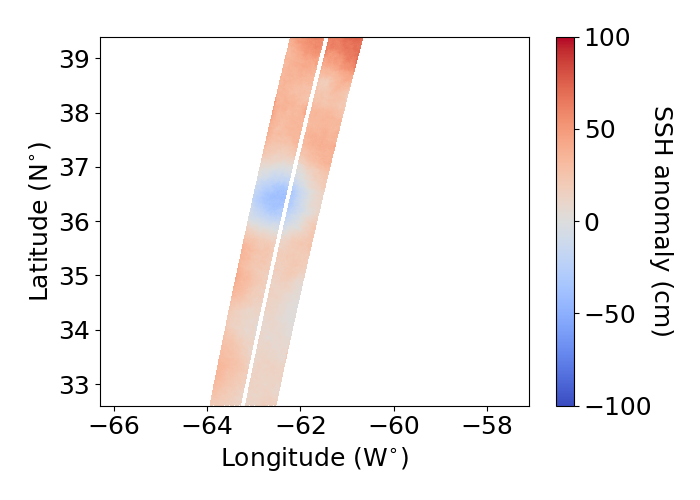

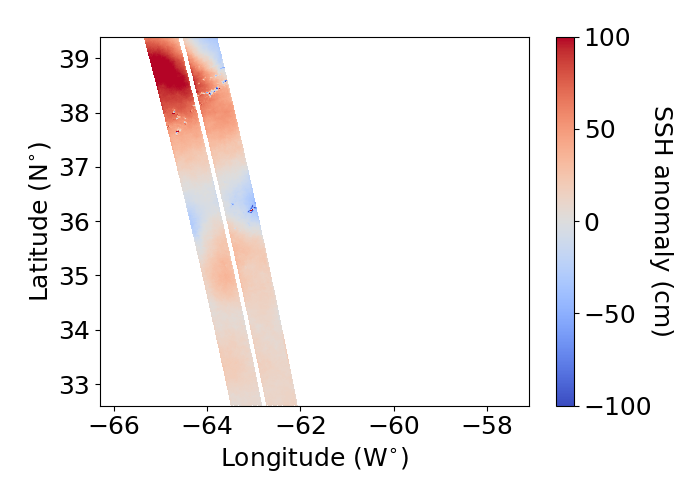

In [14]:
# Later loops can reference skip_datasets to avoid those with errors
for key, ds in datasets.items():
    if key in skip_datasets:
        # Skip any datasets that had issues in previous loops
        print(f"Skipping {key} as it previously caused an error.")
        continue
        
    fig,ax=plt.subplots(figsize=(7,5))
    plot = ax.pcolormesh(datasets[key].longitude,datasets[key].latitude,datasets[key]['ssha']*100,cmap='coolwarm',vmin=-100,vmax=100)    
    cbar = plt.colorbar(plot,ax=ax)
    
    cbar.set_label('SSH anomaly (cm)', rotation=270, labelpad=15)
    
    # Set x and y axis limits (example limits)
    ax.set_xlim([xmin,xmax])  
    ax.set_ylim([ymin,ymax])
    
    ax.set_ylabel('Latitude (N$^{\circ}$)')
    ax.set_xlabel('Longitude (W$^{\circ}$)')
    # ax.set_title(date_requested)
    
    plt.tight_layout()

Regrid SWOT data to regular grid. Need to do this before taking spatial gradients for velocity calculations.

In [15]:
grid_x, grid_y = np.meshgrid(xv, yv)

grid_ssh = {}

for key, ds in datasets.items():
    if key in skip_datasets:
        # Skip any datasets that had issues in previous loops
        print(f"Skipping {key} as it previously caused an error.")
        continue

    unfiltered = griddata((datasets[key].longitude.values.ravel(),datasets[key].latitude.values.ravel()), datasets[key].ssha.values.ravel(), (grid_x, grid_y), method='linear')
    grid_ssh[key] = np.where((unfiltered >= -sht) & (unfiltered <= sht),unfiltered,np.nan)
    
# ssh=ds1_masked.ssha_karin_2+ds1_masked.height_cor_xover
# lat=ds1_masked.latitude
# lon=ds1_masked.longitude
# grid_ssh1 = griddata((datasets[key].longitude.values.ravel(),datasets[key].latitude.values.ravel()), datasets[key].ssh.values.ravel(), (grid_x, grid_y), method='linear')
# ssh=ds2_masked.ssha_karin_2+ds2_masked.height_cor_xover
# lat=ds2_masked.latitude
# lon=ds2_masked.longitude
# grid_ssh2 = griddata((lon.values.ravel(),lat.values.ravel()), ssh.values.ravel(), (grid_x, grid_y), method='linear')

Plot regridded SSH

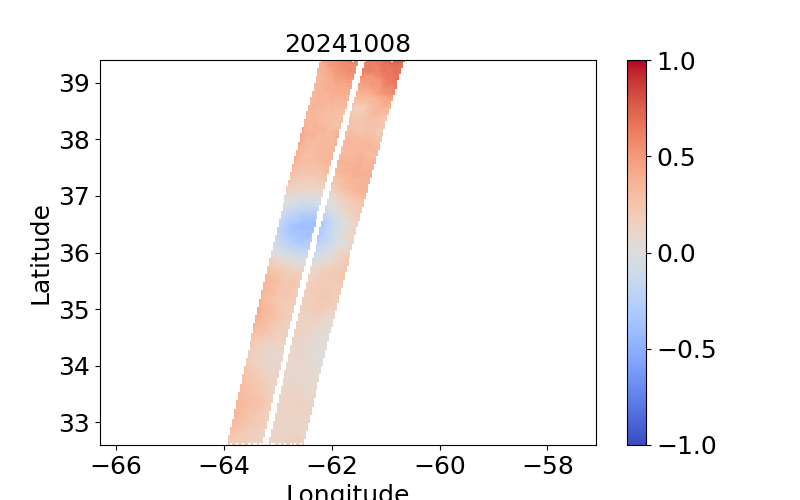

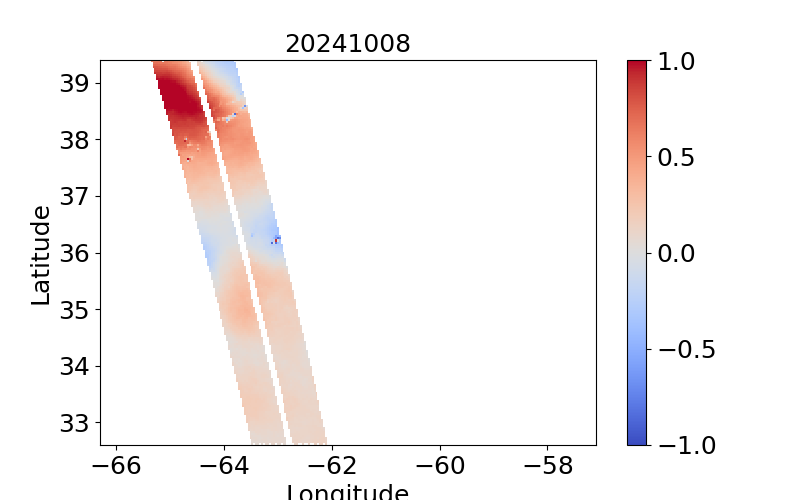

In [16]:
for key, ds in grid_ssh.items():
    if key in skip_datasets:
        # Skip any datasets that had issues in previous loops
        print(f"Skipping {key} as it previously caused an error.")
        continue

    fig,ax=plt.subplots(figsize=(8,5))
    plot = ax.pcolormesh(grid_x,grid_y,grid_ssh[key],cmap='coolwarm',vmin=-1,vmax=1)
    cbar = plt.colorbar(plot,ax=ax)
    
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.set_title(date_requested)
    
    # Set x and y axis limits (example limits)
    ax.set_xlim([xmin,xmax])  
    ax.set_ylim([ymin,ymax])    
    
    plt.show()

In [17]:
def compute_geos_current(ssh,lat):
    omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    fc = 2*omega*np.sin(lat*np.pi/180.)
        # avoid zero near equator, bound fc by min val as 1.e-8
    f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)
    
    dx = 4000 # m i changed it to 4000 to match res? need to double check
    dy = 4000 # m
    gravity = 9.81

    dsdy,dsdx=np.array(np.gradient(ssh, dx, edge_order=1))
    # ds_x,ds_y=np.array(np.gradient(ssh))
    # dsdx=ds_x/dx;
    # dsdy=ds_y/dx;
    vg = (gravity/np.array(f_coriolis))*dsdx
    ug = -(gravity/np.array(f_coriolis))*dsdy
    # ref_gx, ref_gy = gravity/np.array(f_coriolis)*np.array(np.gradient(ssh, dx, edge_order=2))
    geos_current = np.sqrt(ug**2 + vg**2)
    
    return ug,vg,geos_current

Compute geostrophic currents

In [18]:
#Calculate
geos_current = {}

for key, ds in grid_ssh.items():
    if key in skip_datasets:
        # Skip any datasets that had issues in previous loops
        print(f"Skipping {key} as it previously caused an error.")
        continue

    geos_current[key+'_ug'],geos_current[key+'_vg'],geos_current[key] = compute_geos_current(grid_ssh[key],grid_y)


# ug1,vg1,geos_current1 = compute_geos_current(grid_ssh1,grid_y)

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/tmp/ipykernel_162/603128063.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 0.95])


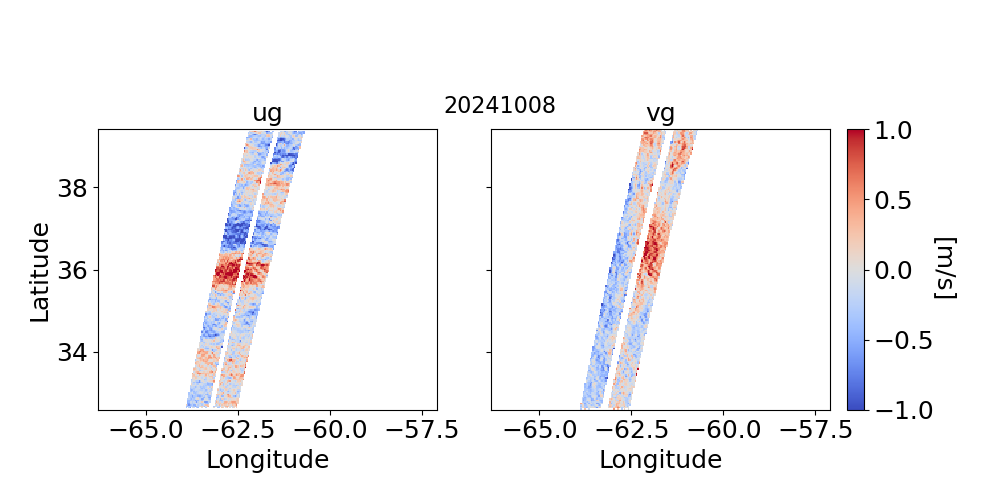

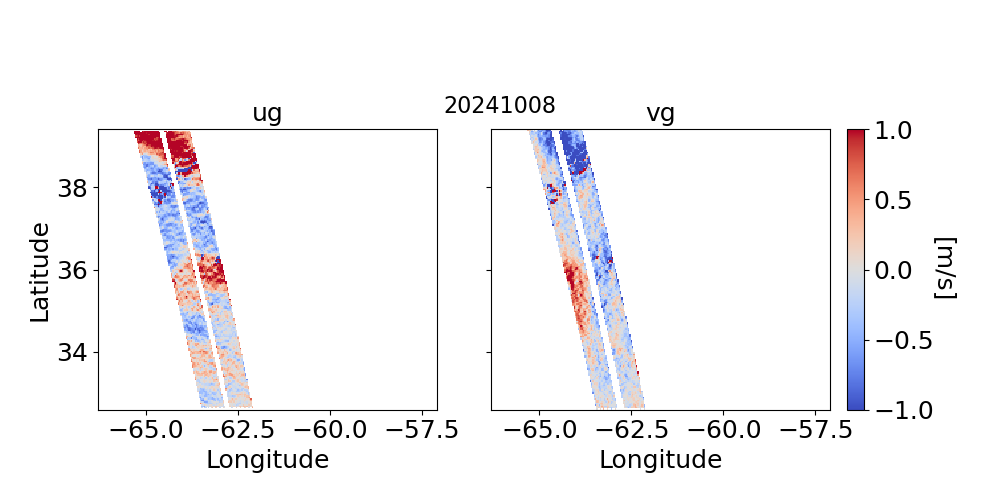

In [20]:
for key, ds in grid_ssh.items():
    if key in skip_datasets:
        # Skip any datasets that had issues in previous loops
        print(f"Skipping {key} as it previously caused an error.")
        continue
        
    # Create subplots with 2 columns, sharing the y-axis
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)

    # Overall title for both plots
    fig.suptitle(date_requested, fontsize=16, y=0.81)
    
    # First plot (ug)
    plot1 = ax1.pcolormesh(grid_x, grid_y, geos_current[key+'_ug'], cmap='coolwarm', vmin=-1, vmax=1)
    ax1.set_ylabel('Latitude')
    ax1.set_xlabel('Longitude')
    ax1.set_title('ug')  # Title for the first plot (ug)
    ax1.set_xlim([xmin, xmax])
    ax1.set_ylim([ymin, ymax])
    
    # Second plot (vg)
    plot2 = ax2.pcolormesh(grid_x, grid_y, geos_current[key+'_vg'], cmap='coolwarm', vmin=-1, vmax=1)
    ax2.set_xlabel('Longitude')
    ax2.set_title('vg')  # Title for the second plot (vg)
    ax2.set_xlim([xmin, xmax])
    ax2.set_ylim([ymin, ymax])  # Redundant due to shared y-axis
    
    # Create an inset_axes for the colorbar on the right, matching the y-axis height
    cax = inset_axes(ax2, width="5%", height="100%", loc='center right', 
                 bbox_to_anchor=(0.1, 0, 1, 1), bbox_transform=ax2.transAxes, borderpad=0)

    # Create a single colorbar for both plots
    cbar = fig.colorbar(plot2, cax=cax)
    cbar.set_label('[m/s]', rotation=270, labelpad=15)
    
    # Use subplots_adjust to manually adjust spacing, avoiding tight_layout issues
    # plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.2)
    plt.tight_layout(rect=[0, 0, 0.88, 0.95])
    
    # Show the plot
    plt.show()

In [21]:
def compute_relative_vorticity(ug, vg, lat):
    omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    fc = 2*omega*np.sin(lat*np.pi/180.)
        # avoid zero near equator, bound fc by min val as 1.e-8
    f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)
    
    # ds = self._dset
        
    dx = 4000 # m
    dy = 4000 # m
        
    # du_dx, du_dy = np.gradient(ug, dx, edge_order=2)
    # dv_dx, dv_dy = np.gradient(vg, dx, edge_order=2)
    du_dy, du_dx = np.gradient(ug, dx, edge_order=2)
    dv_dy, dv_dx = np.gradient(vg, dx, edge_order=2)
        
    ksi = (dv_dx - du_dy)/f_coriolis
        
    return ksi

Compute geostrophic vorticity. Smoothing is in the x,y direction, not along track, which is why the swath shrinks. Future problem to fix to increase swath of vorticity

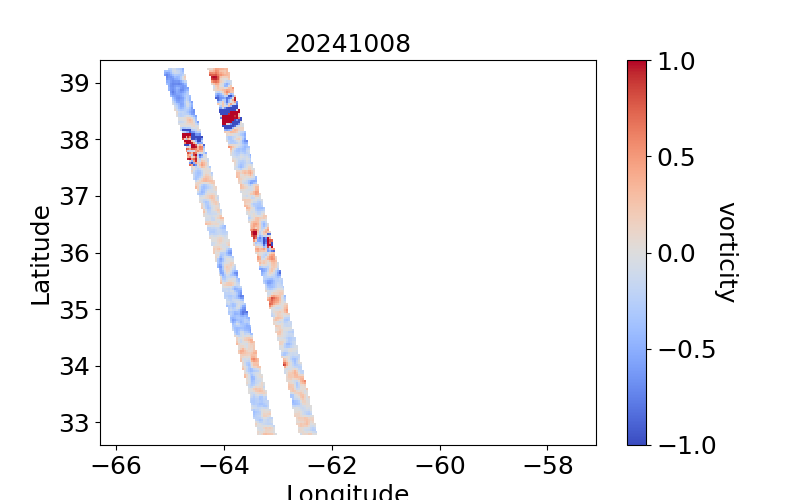

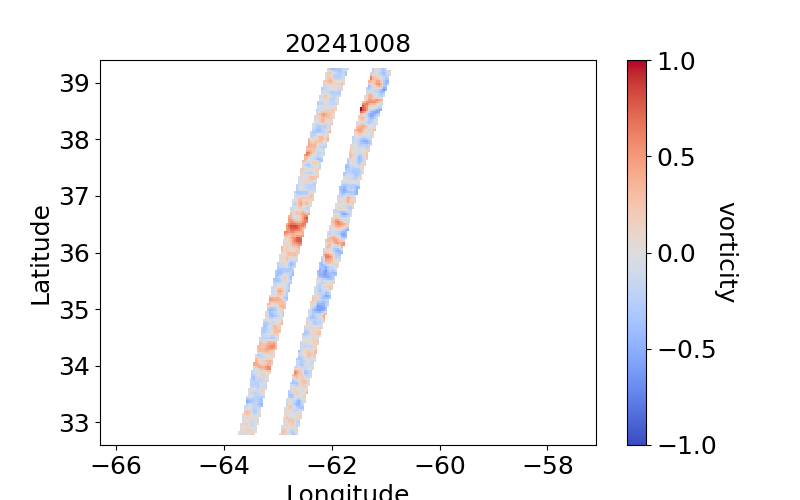

In [22]:
wfl=5
ksi =  {}

for key, ds in grid_ssh.items():
    if key in skip_datasets:
        # Skip any datasets that had issues in previous loops
        print(f"Skipping {key} as it previously caused an error.")
        continue
        
    ug_smooth = xr.apply_ufunc(generic_filter,geos_current[key+'_ug'], np.mean, [wfl,wfl])
    vg_smooth = xr.apply_ufunc(generic_filter,geos_current[key+'_vg'], np.mean, [wfl,wfl])
    
    ksi[key+'_ksi'] = compute_relative_vorticity(ug_smooth, vg_smooth, grid_y)
    
    fig,ax = plt.subplots(figsize=(8,5))
    plot = ax.pcolormesh(grid_x,grid_y,ksi[key+'_ksi'],cmap='coolwarm',vmin=-1,vmax=1)
    
    cbar = plt.colorbar(plot,ax=ax)
    
    cbar.set_label('vorticity', rotation=270, labelpad=15)
    
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.set_title(date_requested)
    
    # Set x and y axis limits (example limits)
    ax.set_xlim([xmin,xmax])  
    ax.set_ylim([ymin,ymax])

plt.show()

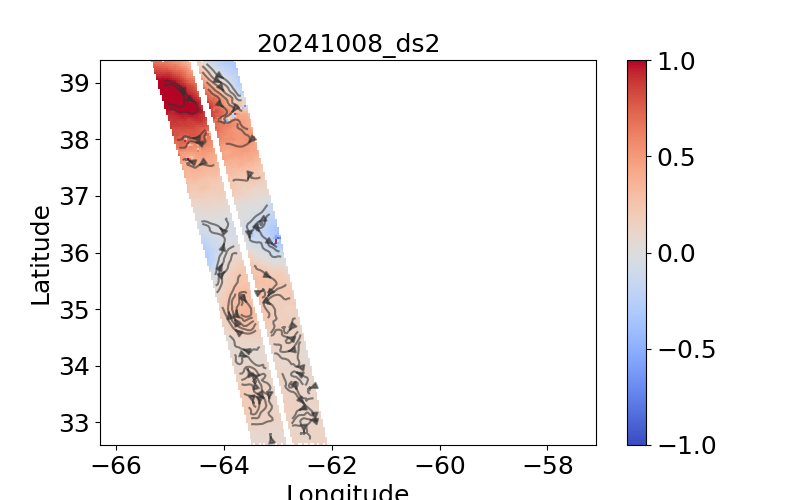

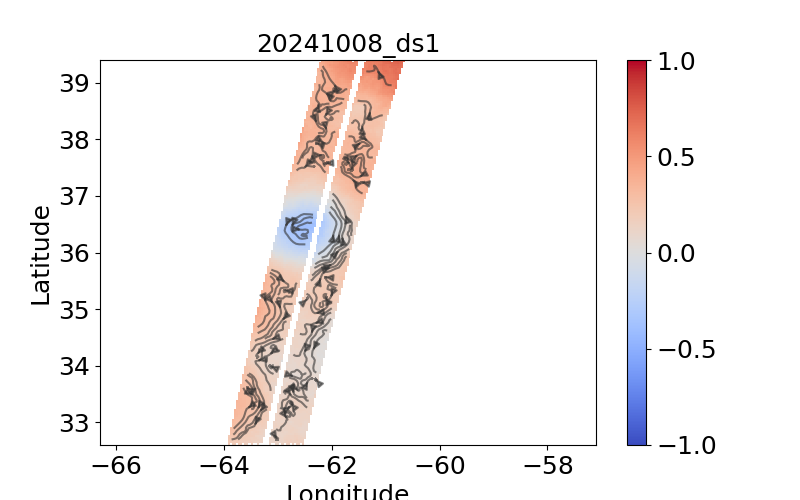

In [23]:
for key, ds in grid_ssh.items():
    
    fig,ax=plt.subplots(figsize=(8,5))
    
    plot = ax.pcolormesh(grid_x,grid_y,grid_ssh[key],cmap='coolwarm',vmin=-1,vmax=1)
    cbar = plt.colorbar(plot,ax=ax)
    
    plt.streamplot(grid_x,grid_y,geos_current[key+'_ug'],geos_current[key+'_vg'], density = 5, color = (0.2,0.2,0.2,0.6))
    
    # cbar.set_label('dsdx', rotation=270, labelpad=15)
    
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.set_title(f'{date_requested}_{key}')
    
    # Set x and y axis limits (example limits)
    ax.set_xlim([xmin,xmax])  
    ax.set_ylim([ymin,ymax])   

plt.show()

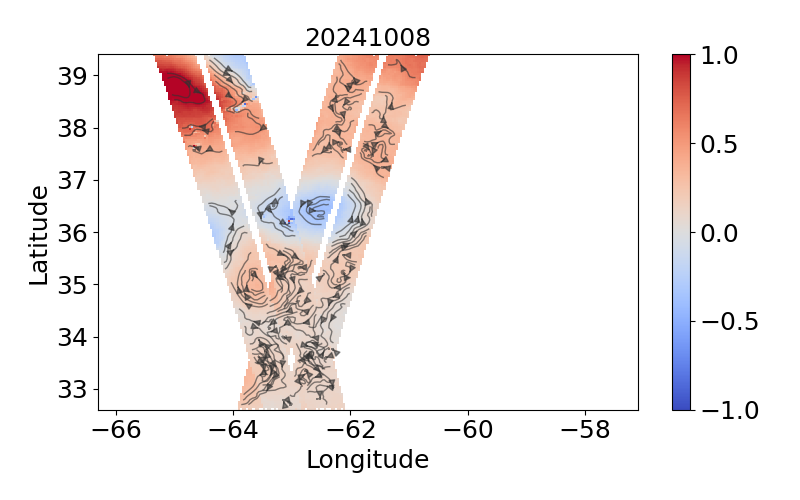

In [24]:
fig,ax=plt.subplots(figsize=(8,5))

for key, ds in grid_ssh.items():
    plot = ax.pcolormesh(grid_x,grid_y,grid_ssh[key],cmap='coolwarm',vmin=-1,vmax=1)
    
    plt.streamplot(grid_x,grid_y,geos_current[key+'_ug'],geos_current[key+'_vg'], linewidth=1,density = 5, color = (0.2,0.2,0.2,0.6))
    
    # cbar.set_label('dsdx', rotation=270, labelpad=15)

cbar = plt.colorbar(plot,ax=ax)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

# Set x and y axis limits (example limits)
ax.set_xlim([xmin,xmax])  
ax.set_ylim([ymin,ymax])   

plt.tight_layout()

# Landsat SST with SWOT - Not useful for Gulf Stream

In [25]:
from pathlib import Path
import os
from rasterio.session import AWSSession
import boto3
import pystac_client
import intake
import geopandas as gpd
import hvplot.pandas
import geoviews as gv
from pyproj import Proj, transform
from shapely.geometry.polygon import Polygon, Point
import gc
import cartopy
import cartopy.crs as ccrs
import rioxarray

In [26]:
# Define the landsat STAC catalog location
url = 'https://landsatlook.usgs.gov/stac-server'

# For atm correction
basepath = Path('/home/jovyan/GO-SWACE')
lsatpath = basepath / 'Data'

# For search and tile plot for Landsat
satellite = 'Landsat8'
collection = 'landsat-c2l1' # Landsat Collection 2, Level 1 - includes L8 and L9
colnm = ['landsat:wrs_path','landsat:wrs_row']
gjson_outfile = lsatpath / f'{satellite}.geojson'

# SSTpath = lsatpath / 'SST/MODcalib/Burke/'

In [41]:
# Authenticate for boto S3 access, etc.
os.environ["AWS_REQUEST_PAYER"] = "requester"
aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [42]:
# Setup and authenticate 
from dask.distributed import Client
import logging
client = Client(processes=True, n_workers=4, 
                threads_per_worker=1,
                silence_logs=logging.ERROR)
client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
client

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39045 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:35345' processes=4 threads=4, memory=29.67 GiB>

In [43]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")

# If we are not authenticated
if not auth.authenticated:
    # Ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [44]:
timeRange = f'{tmin}/{tmax}'

In [45]:
# Search for desired Landsat scenes
items = search_stac(url,bbox,timeRange,collection,gjson_outfile)

# Open stac catalog for some needed info
catalog = intake.open_stac_item_collection(items)

# Load the geojson file
gf = gpd.read_file(gjson_outfile)

7 Landsat 8/9 items


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


In [46]:
# Plot tiles of all scenes found
plot_search(gf,satellite,colnm)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (landsat:wrs_path,landsat:wrs_row)

**Note the bands you would like to include are assigned by passing the bandNames parameter to landsat_to_xarray using the following codes:**

'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'pan', 'cirrus', 'lwir11', 'lwir12', 'qa_pixel'

## Process Landsat scenes to acquire sea surface temperature

In [47]:
# Convert bounding box to polar for checking if landsat has any data in bounding box
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the file

sbox,checkbox = lsat_reproj(source_crs,target_crs,(bbox[0],bbox[1],bbox[2],bbox[3]))

# Create polygon for later cropping
polygon = Polygon([(sbox[0][0],sbox[0][1]),(sbox[3][0],sbox[3][1]),(sbox[2][0],sbox[2][1]),(sbox[1][0],sbox[1][1])])

# Create min/max boundaries for trimming image before crop_xarray to cut down on processing times
minx, miny, maxx, maxy = polygon.bounds
polarx = [minx, maxx]
polary = [miny, maxy]

lsat_reproj normal orientation
bbox=[(-1633094.2156356454, -527475.059352907), (-1538438.8797202434, -496902.2188811082), (-1597664.8852308732, -247331.59172266288), (-1695964.212155886, -262549.1315324062)]
lbox=(-107.9, -75.2, -98.8, -74.3)
checkbox=[-107.9  -75.2  -98.8  -74.3]


/srv/conda/envs/notebook/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/srv/conda/envs/notebook/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_1200/1959275362.py:213: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  [lULX,lLRX], [lULY,

In [48]:
catalog_list = [x for x in items if (x.id[3]=='8' or x.id[3]=='9')]
catalog_list

[<Item id=LC09_L1GT_001114_20240104_20240104_02_T2>,
 <Item id=LC09_L1GT_001113_20240104_20240104_02_T2>,
 <Item id=LC09_L1GT_001112_20240104_20240104_02_T2>,
 <Item id=LC08_L1GT_162131_20240104_20240112_02_T2>,
 <Item id=LC08_L1GT_162130_20240104_20240112_02_T2>,
 <Item id=LC09_L1GT_154132_20240104_20240104_02_T2>,
 <Item id=LC09_L1GT_154131_20240104_20240104_02_T2>]

In [49]:
bands = []


# Include only Landsat 8 scenes
catalog_list = [x for x in items if (x.id[3]=='8' or x.id[3]=='9')]

for sceneid in catalog_list[0:2]: #20231214 was [4:6]
    print(sceneid.id)
    
    scene = catalog[sceneid.id]
    timestr = scene.metadata['datetime'].strftime('%Y%m%d %H:%M:%S')
    
    # Open all desired bands for one scene
    ls_scene = ls_thermal_to_xarray(sceneid,bandNames=['lwir11'])
    ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)
    
    # Create classification mask
    ls_scene = create_masks(ls_scene, cloud_mask=True, ice_mask=True, ocean_mask=True)
    
    # try:
    # Check for any open ocean pixels in bounding box - go to next image if none - 9.3 s
    mask = np.ones(ls_scene.shape[1:])
    mask[ls_scene.mask!=3] = np.nan
    ls_thermal = ls_scene.sel(band='lwir11').compute()
    ls_box = subset_img(ls_thermal,polarx,polary) #ls_thermal*mask
    # ls_box = ls_box.where(ls_box >= -3.5, np.nan)  # thermal only
    
    if ((ls_box).notnull()).sum().values==0:
        print (f'{sceneid.id} has no SSTs')
        try:
            del ls_scene, scene, mask, ls_thermal, ls_box
        except:
            pass
        gc.collect()
        continue
    
    # Construct xarray for scene
    ls_box.coords['id'] = sceneid.id
    ls_box.coords['time'] = timestr
    bands.append(ls_box)
        
    # except Exception as e:
    #     print (f'{sceneid.id} has no SSTs: {e}')
    
    # try:
    #     del ls_scene, scene, ls_thermal, ls_box
    # except:
    #     pass
    
    gc.collect()

ls_scenes = xr.concat(bands, dim='time')

LC09_L1GT_001114_20240104_20240104_02_T2
(8411, 2489)
LC09_L1GT_001113_20240104_20240104_02_T2
(7086, 5251)


In [50]:
# Select scene to plot
p = 1
ls = ls_scenes.sel(time=ls_scenes.time.values[p])

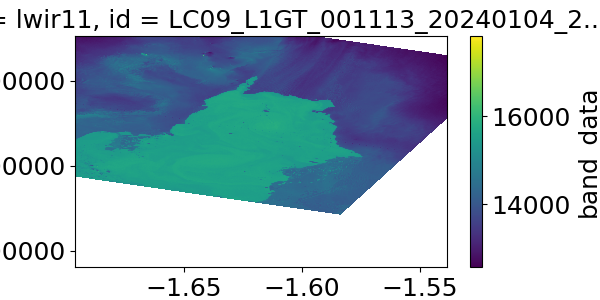

In [51]:
# Quick plot
plt.figure(figsize=(6, 3))
ls.plot.imshow(x='x',y='y')#,vmin=0,vmax=0.0008)

In [39]:
# # Slow plot in cartopy
# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# cb = ax.pcolormesh(ls_scenes.x,ls_scenes.y,ls,alpha=0.3,transform=cartopy.crs.epsg(3031))
# plt.streamplot(grid_x, grid_y, geos_current[key+'_ug'], geos_current[key+'_vg'], 
#                density=2, color=(0.2, 0.2, 0.2, 0.6)) 
# ax.coastlines(resolution='110m')
# ax.set_ylim([bbox[1], bbox[3]])
# ax.set_xlim([bbox[0], bbox[2]])
# # plt.colorbar(cb)
# plt.tight_layout()

In [52]:
# Reproject to EPSG:4326
ls = ls_scenes.sel(time=ls_scenes.time.values[p])
ls = ls.drop_vars('mask')
ls_rp = ls.rio.reproject("EPSG:4326")
ls_rp

<xarray.DataArray 'band_data' (y: 2513, x: 13338)> Size: 134MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 107kB -108.6 -108.6 -108.6 ... -98.3 -98.3 -98.3
  * y            (y) float64 20kB -73.78 -73.78 -73.78 ... -75.73 -75.73 -75.73
    band         <U8 32B 'lwir11'
    id           <U40 160B 'LC09_L1GT_001113_20240104_20240104_02_T2'
    time         <U17 68B '20240104 14:52:04'
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point

In [38]:
key = 'ds1'
# key = 'ds2'
# key = 'ds3'

In [53]:
from matplotlib.colors import TwoSlopeNorm

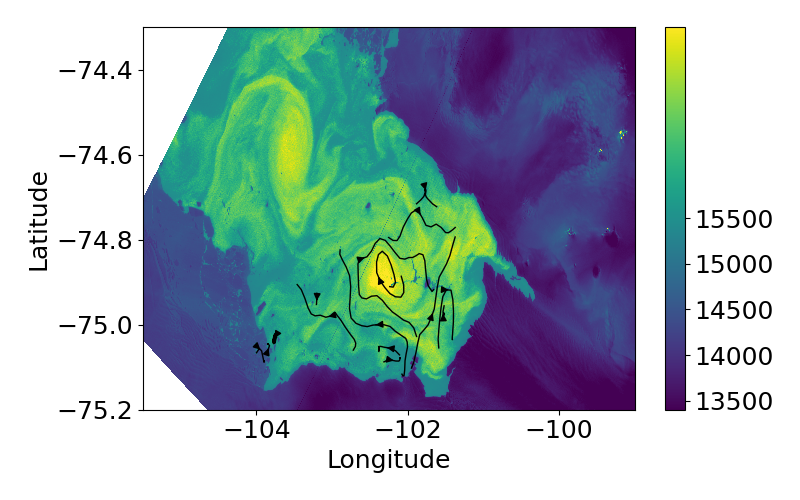

In [99]:
# Medium fast plot in matplotlib

gc.collect()

fig,ax=plt.subplots(figsize=(8,5))

midpoint = 15500
plot = ax.pcolormesh(ls_rp.x,ls_rp.y,ls_rp,norm=TwoSlopeNorm(vmin=13400, vmax=15800, vcenter=midpoint)) # 20231214 ,norm=TwoSlopeNorm(vmin=14000, vmax=17500, vcenter=midpoint)
#vmin=16700,vmax=17300 20240215; 2023115 vmin=14600,vmax=15600 or vmin=11500,vmax=15400; 20231214 ,vmin=16900,vmax=17500  or ,vmin=16900,vmax=17500
cbar = plt.colorbar(plot,ax=ax)

key = 'ds3'
plt.streamplot(grid_x,grid_y,geos_current[key+'_ug'],geos_current[key+'_vg'], linewidth=1,density = 5, color = 'k')
# key = 'ds1'
# plt.streamplot(grid_x,grid_y,geos_current[key+'_ug'],geos_current[key+'_vg'], density = 2, color = 'k')

# cbar.set_label('dsdx', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
# ax.set_title(date_requested)

# Set x and y axis limits (example limits)
# ax.set_xlim([-106.5,-100])  # 20231214
# ax.set_ylim([-75.2,-74.3])
ax.set_xlim([-105.5,-99])  # 20240104
ax.set_ylim([-75.2,-74.3])

plt.tight_layout()

# MODIS SST with SWOT

In [25]:
from datetime import date, timedelta, datetime
import pandas as pd
import pytz

In [26]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")

# If we are not authenticated
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [27]:
def find_MODIS_SWOT(lonboundsC,latboundsC,ls_time):
        '''
        Finds the MODIS scene most closely coincident to a Landsat scene
        Uses full Landsat scene extent, not cropped
        
        Variables: 
        ls_scene = xarray for one Landsat scene
        
        Outputs:
        mod_scene = xarray of MODIS SST image coincident in time with the Landsat scene
        granules[ind]['umm']['GranuleUR'] = modis file name
        min_time = the time difference between the Landsat image acquisition and chosen MODIS image
        
        **not done, Differences from NLSST: 0.0 used as percent_dif requiring 100% overlap between MODIS and Landsat here since the subset area is so small
        '''
        
        # To convert from K to C
        KtoC = -273.15
    
        mbox = (lonboundsC[0],latboundsC[0],lonboundsC[1],latboundsC[1]) #east, south,west,north
        lsatpoly = Polygon([(lonboundsC[0],latboundsC[1]),(lonboundsC[0],latboundsC[0]),(lonboundsC[1],latboundsC[0]),(lonboundsC[1],latboundsC[1]),(lonboundsC[0],latboundsC[1])])
        
        # Get date/time for Landsat image and search for corresponding MODIS imagery  
        calc_dt = datetime.strptime(ls_time, '%Y-%m-%d %H:%M:%S').replace(tzinfo=pytz.UTC)
        # start_dt = (calc_dt + timedelta(days=-0.5)).strftime('%Y-%m-%d %H:%M:%S')
        # end_dt = (calc_dt + timedelta(days=0.5)).strftime('%Y-%m-%d %H:%M:%S')
        # Set to beginning and end of the same day
        start_dt = calc_dt.replace(hour=0, minute=0, second=0).strftime('%Y-%m-%d %H:%M:%S')
        end_dt = calc_dt.replace(hour=23, minute=59, second=59).strftime('%Y-%m-%d %H:%M:%S')
        
        # Gather all files from search location from Terra and Aqua for the same day as the Landsat image
        granules = earthaccess.search_data(
            short_name='MODIS_T-JPL-L2P-v2019.0',
            bounding_box=mbox,
            # Day of a landsat scene to day after - searches day of only
            temporal=(start_dt,end_dt)
        )
        granules2 = earthaccess.search_data(
            short_name='MODIS_A-JPL-L2P-v2019.0', #MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_NIGHTTIME_V2019.0
            bounding_box=mbox,
            # Day of a landsat scene to day after - searches day of only
            temporal=(start_dt,end_dt)
        )
        granules = granules + granules2
        print (f'{len(granules)} TOTAL MODIS granules')
        
        # Filter granules by spatial overlap
        best_grans = []
        granule_times = []
        for granule in granules:
            try:
                gpolys = granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons']
                for gpoly in gpolys:
                    map_points = [(p['Longitude'], p['Latitude']) for p in gpoly['Boundary']['Points']]
                    pgon = Polygon(map_points)
                    if lsatpoly.difference(pgon).area / lsatpoly.area <= 20.0:
                        if not crosses_idl(map_points):
                            best_grans.append(granule)
                            granule_times.append(pd.to_datetime(granule['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']))
                            break
            except Exception as e:
                print(f"Skipping granule due to error: {e}")
        
        print(f'{len(best_grans)} remaining MODIS granules')
        
        paths = earthaccess.open(best_grans)
        
        # Open all remaining granules as xarray datasets
        mod_scenes = []
        filenames = []
        for granule, gtime in zip(paths, granule_times):
            try:
                ds = xr.open_dataset(granule,decode_timedelta=True)
                ds = ds.rio.write_crs("epsg:4326", inplace=True)
            
                # Add time_dif as a variable (in seconds)
                time_diff_seconds = (gtime - calc_dt).total_seconds()
                ds["time_dif"] = xr.DataArray(time_diff_seconds, attrs={"units": "seconds", "description": "Time difference between MODIS and Landsat"}, dims=())
                ds['sea_surface_temperature'] = (ds.sea_surface_temperature + KtoC).where(ds.sea_surface_temperature + KtoC > -55.5, np.nan)
            
                mod_scenes.append(ds)
                filenames.append(granule.full_name)
            except Exception as e:
                print(f"Failed to open MODIS file: {e}")
        
        if not mod_scenes:
            print("⚠️ No MODIS datasets successfully opened.")
        
        mod_combined = xr.concat(mod_scenes, dim="time", combine_attrs="override")
    
        return mod_combined, paths
    
        # # Find MODIS image closest in time to each Landsat image
        # # Make Landsat datetime timezone aware (UTC)
        # Mdates = [pd.to_datetime(granule['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']) for granule in best_grans]
        # # ind = Mdates.index(min( Mdates, key=lambda x: abs(x - pytz.utc.localize(ls_time))))
        # ind = Mdates.index(min( Mdates, key=lambda x: abs(x - calc_dt)))
        # time_dif = abs(Mdates[ind] - calc_dt)
        # print(f'Time difference between MODIS and Landsat: {time_dif}')
    
        # mod_scene = xr.open_dataset(earthaccess.open(best_grans[ind:ind+1])[0])
        # mod_scene = mod_scene.rio.write_crs("epsg:4326", inplace=True) 
        
        # return mod_scene, granules[ind]['umm']['GranuleUR'],time_dif

In [28]:
latboundsC = [ bbox[1] , bbox[3] ] # Dotson polynya
lonboundsC = [ bbox[0] , bbox[2] ]

for swot_path in swot_paths[0:1]:
    nm = swot_path.full_name
    swot_time = f'{nm[-42:-38]}-{nm[-38:-36]}-{nm[-36:-34]} {nm[-33:-31]}:{nm[-31:-29]}:{nm[-29:-27]}'
    # swot_time = '2023-12-14 14:15:54'
    # swot_time = '2024-05-08 20:23:17'
    # Find coincident MODIS SST scene
    # mod_scene, mod_file,time_dif = find_MODIS_SWOT(lonboundsC,latboundsC,swot_time)
    mod_scenes, mod_files = find_MODIS_SWOT(lonboundsC,latboundsC,swot_time)
    # Convert temperature from Kelvin to Celsius and apply condition
    # mod_scene['sea_surface_temperature'] = (mod_scene.sea_surface_temperature + KtoC).where(mod_scene.sea_surface_temperature + KtoC > -55.5, np.nan)
    # print(swot_time)
    # print(mod_file)

6 TOTAL MODIS granules
6 remaining MODIS granules


QUEUEING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/6 [00:00<?, ?it/s]

In [63]:
key = 'ds1'
# key = 'ds2'
# key = 'ds3'

In [65]:
mod_scenes

<xarray.Dataset> Size: 907MB
Dimensions:                      (time: 5, nj: 2030, ni: 1354)
Coordinates:
    lat                          (time, nj, ni) float32 55MB 49.64 ... 21.99
    lon                          (time, nj, ni) float32 55MB -71.6 ... -60.61
  * time                         (time) datetime64[ns] 40B 2024-10-05T14:00:0...
    spatial_ref                  int64 8B 0
Dimensions without coordinates: nj, ni
Data variables: (12/15)
    sea_surface_temperature      (time, nj, ni) float32 55MB nan nan ... 271.4
    sst_dtime                    (time, nj, ni) timedelta64[ns] 110MB 00:00:0...
    quality_level                (time, nj, ni) float32 55MB 0.0 0.0 ... 1.0 1.0
    sses_bias                    (time, nj, ni) float32 55MB nan nan ... -14.49
    sses_standard_deviation      (time, nj, ni) float32 55MB nan nan ... 13.23
    l2p_flags                    (time, nj, ni) int16 27MB 2 2 2 2 2 ... 0 0 0 0
    ...                           ...
    sea_surface_temperature_4um  (time, nj, ni) float32 55MB nan nan ... 273.2
    quality_level_4um            (time, nj, ni) float32 55MB nan nan ... 1.0 1.0
    sses_bias_4um                (time, nj, ni) float32 55MB nan nan ... -14.33
    sses_standard_deviation_4um  (time, nj, ni) float32 55MB nan nan ... 12.13
    chlorophyll_a                (time, nj, ni) float32 55MB nan nan ... nan nan
    K_490                        (time, nj, ni) float32 55MB nan nan ... nan nan
Attributes: (12/49)
    Conventions:                CF-1.7, ACDD-1.3
    title:                      MODIS Terra L2P SST
    summary:                    Sea surface temperature retrievals produced a...
    references:                 GHRSST Data Processing Specification v2r5
    institution:                NASA/JPL/OBPG/RSMAS
    history:                    MODIS L2P created at JPL PO.DAAC
    ...                         ...
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L2P
    cdm_data_type:              swath
    startDirection:             Descending
    endDirection:               Descending
    day_night_flag:             Day

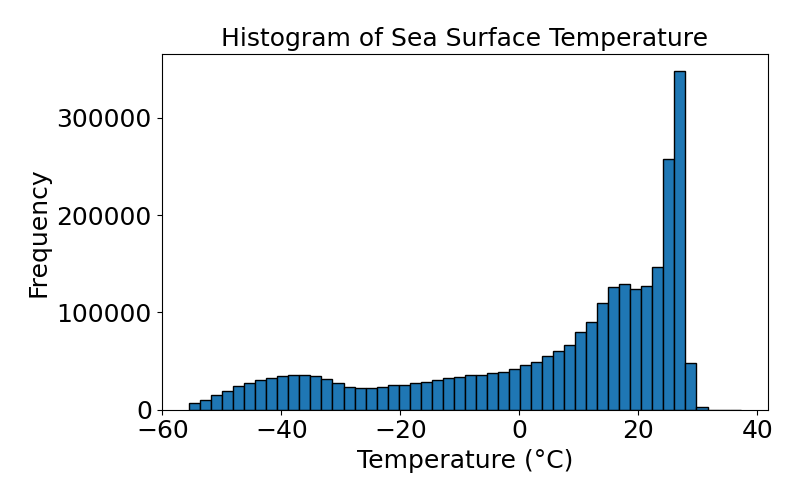

In [143]:
# Flatten the DataArray and drop NaNs
data = mod_scenes.isel(time=0).sea_surface_temperature.squeeze().values
data = data[~np.isnan(data)]

# Medium-fast histogram plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(data, bins=50, edgecolor='black')  # Adjust bins as needed
ax.set_title("Histogram of Sea Surface Temperature")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

In [146]:
sst = mod_scenes.sea_surface_temperature
sst

<xarray.DataArray 'sea_surface_temperature' (time: 6, nj: 2030, ni: 1354)> Size: 66MB
array([[[ 26.274994  ,  26.494995  ,  26.505005  , ...,  26.934998  ,
          26.48999   ,  27.059998  ],
        [ 26.290009  ,  26.619995  ,  26.605011  , ...,  26.380005  ,
          26.410004  ,  26.730011  ],
        [ 26.154999  ,  26.609985  ,  26.454987  , ...,  26.984985  ,
          26.434998  ,  26.514984  ],
        ...,
        [ 20.700012  ,  22.350006  ,  20.61499   , ..., -48.244995  ,
         -48.649994  , -48.449997  ],
        [ 17.859985  ,  16.665009  ,  19.859985  , ..., -46.744995  ,
         -47.550003  , -47.559998  ],
        [ 17.029999  ,  16.320007  ,  18.730011  , ..., -44.75      ,
         -47.765     , -46.949997  ]],

       [[ 14.375     ,  21.049988  ,  20.755005  , ..., -47.320007  ,
         -49.199997  , -49.024994  ],
        [ 18.375     ,  21.76001   ,  21.730011  , ..., -48.024994  ,
         -48.164993  , -49.03      ],
        [ 20.304993  ,  22.415009  ,  20.214996  , ..., -47.625     ,
         -48.255005  , -48.5       ],
...
        [ 28.75      ,  28.924988  ,  29.204987  , ...,  28.700012  ,
          28.815002  ,  28.700012  ],
        [ 28.839996  ,  28.459991  ,  28.910004  , ...,  29.244995  ,
          28.804993  ,  28.76001   ],
        [ 28.        ,  28.704987  ,  28.945007  , ...,  29.079987  ,
          29.154999  ,  29.154999  ]],

       [[ 25.165009  ,  25.61499   ,  25.690002  , ...,  30.014984  ,
          30.01001   ,  29.660004  ],
        [ 25.470001  ,  25.154999  ,  25.565002  , ...,  29.589996  ,
          29.350006  ,  29.744995  ],
        [ 25.820007  ,  25.095001  ,  25.619995  , ...,  29.595001  ,
          29.670013  ,  29.720001  ],
        ...,
        [  7.1849976 ,   6.6650085 ,   7.5150146 , ...,  16.904999  ,
          16.910004  ,  17.089996  ],
        [  8.535004  ,   7.8900146 ,  10.320007  , ...,  16.959991  ,
          17.160004  ,  17.144989  ],
        [  8.549988  ,   8.255005  ,   8.859985  , ...,  17.014984  ,
          17.459991  ,  17.029999  ]]], dtype=float32)
Coordinates:
    lat          (time, nj, ni) float32 66MB 20.56 20.56 20.56 ... 41.09 41.07
    lon          (time, nj, ni) float32 66MB -31.93 -31.97 ... -71.73 -71.78
  * time         (time) datetime64[ns] 48B 2024-10-05T00:20:01 ... 2024-10-05...
    spatial_ref  int64 8B 0
Dimensions without coordinates: nj, ni

In [144]:
# Flatten the DataArray and drop NaNs
data = mod_scenes.isel(time=0).sea_surface_temperature.squeeze().values
data = data[~np.isnan(data)]

# Compute the 90th percentile of temperature (or try 95th)
Lthresh = np.percentile(data, 65)  # You can adjust this value as needed
Uthresh = np.percentile(data, 99.5)  # You can adjust this value as needed

# print(f"Upper threshold (approx. top 10% of temps): {Uthresh:.2f} °C")
# print(f"Lower threshold (approx. top 10% of temps): {Lthresh:.2f} °C")

warm_mask = data >= Lthresh
data = data*warm_mask
data = data.where(data>0,np.nan)

Upper threshold (approx. top 10% of temps): 28.95 °C
Lower threshold (approx. top 10% of temps): 20.18 °C


/tmp/ipykernel_143/2451211794.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = ax.pcolormesh(data.lon,data.lat,data,vmin=Lthresh,vmax=Uthresh) #,vmin=-3.5,vmax=0.0....,vmin=-2.0,vmax=-0.5


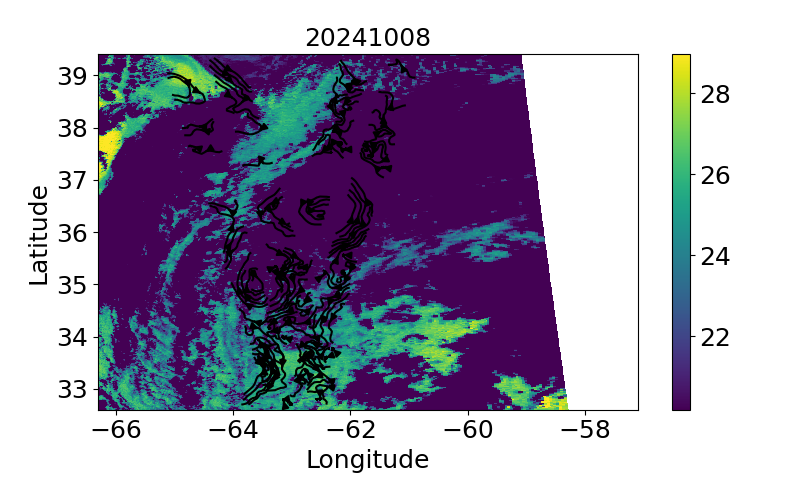

In [145]:
data = mod_scenes.isel(time=2).sea_surface_temperature.squeeze()
warm_mask = data >= Lthresh
data = data*warm_mask
data = data.where(data>0,np.nan)

# Medium fast plot in matplotlib
fig,ax=plt.subplots(figsize=(8,5))
    
plot = ax.pcolormesh(data.lon,data.lat,data,vmin=Lthresh,vmax=Uthresh) #,vmin=-3.5,vmax=0.0....,vmin=-2.0,vmax=-0.5
cbar = plt.colorbar(plot,ax=ax)

key = 'ds1'
plt.streamplot(grid_x,grid_y,geos_current[key+'_ug'],geos_current[key+'_vg'], density = 5, color = 'k')
key = 'ds2'
plt.streamplot(grid_x,grid_y,geos_current[key+'_ug'],geos_current[key+'_vg'], density = 5, color = 'k')
# cbar.set_label('dsdx', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

# Set x and y axis limits (example limits)
ax.set_xlim([xmin,xmax])  
ax.set_ylim([ymin,ymax])
# ax.set_xlim([-107.5,-100])  
# ax.set_ylim([-75.2,-74.3])
# ax.set_ylim([34,38])
# ax.set_xlim([-73,-68])

plt.tight_layout()

In [29]:
# Define your target grid
lat_target = np.arange(-90, 90.01, 0.05)  # adjust as needed
lon_target = np.arange(-180, 180.01, 0.05)

# Create a 2D meshgrid for interpolation
lon2d, lat2d = np.meshgrid(lon_target, lat_target)


In [ ]:
mod_combined = xr.concat(mod_scenes, dim="time", combine_attrs="override")

/tmp/ipykernel_143/257321160.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = ax.pcolormesh(mod_scenes.isel(time=1).lon,mod_scenes.isel(time=1).lat,data,vmin=Lthresh,vmax=Uthresh) #,vmin=-3.5,vmax=0.0....,vmin=-2.0,vmax=-0.5


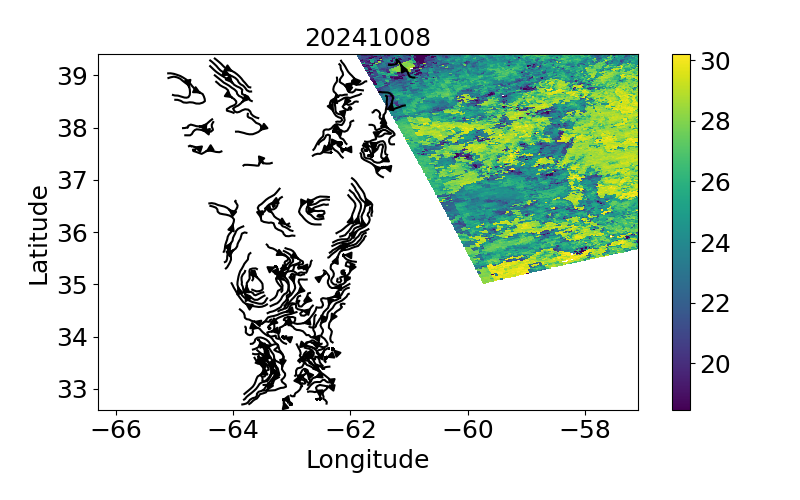

In [152]:
# Assume mod_scenes is your xarray.Dataset and contains 'sea_surface_temperature'
sst = mod_scenes.sea_surface_temperature

# Create an empty list to hold masked arrays
masked_scenes = []

# Loop through each time step
for i in range(sst.sizes['time']):
    scene = sst.isel(time=i)
    
    # Flatten and drop NaNs for percentile calculation
    flat_data = scene.values.flatten()
    flat_data = flat_data[~np.isnan(flat_data)]

    # Skip this time if too few valid pixels
    if len(flat_data) < 100:
        continue

    # Compute dynamic thresholds
    Lthresh = np.percentile(flat_data, 65)
    Uthresh = np.percentile(flat_data, 99.5)

    # Apply thresholding
    masked = scene.where((scene >= Lthresh) & (scene <= Uthresh))

    masked_scenes.append(masked)

# Stack and compute average across time, ignoring NaNs
masked_stack = xr.concat(masked_scenes, dim='time')
data = masked_stack.mean(dim='time', skipna=True)

# Medium fast plot in matplotlib
fig,ax=plt.subplots(figsize=(8,5))
    
plot = ax.pcolormesh(mod_scenes.isel(time=1).lon,mod_scenes.isel(time=1).lat,data,vmin=Lthresh,vmax=Uthresh) #,vmin=-3.5,vmax=0.0....,vmin=-2.0,vmax=-0.5
cbar = plt.colorbar(plot,ax=ax)

key = 'ds1'
plt.streamplot(grid_x,grid_y,geos_current[key+'_ug'],geos_current[key+'_vg'], density = 5, color = 'k')
key = 'ds2'
plt.streamplot(grid_x,grid_y,geos_current[key+'_ug'],geos_current[key+'_vg'], density = 5, color = 'k')
# cbar.set_label('dsdx', rotation=270, labelpad=15)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(date_requested)

# Set x and y axis limits (example limits)
ax.set_xlim([xmin,xmax])  
ax.set_ylim([ymin,ymax])
# ax.set_xlim([-107.5,-100])  
# ax.set_ylim([-75.2,-74.3])
# ax.set_ylim([34,38])
# ax.set_xlim([-73,-68])

plt.tight_layout()

In [148]:
data

<xarray.DataArray 'sea_surface_temperature' (nj: 2030, ni: 1354)> Size: 11MB
array([[24.017502, 25.969994, 24.316671, ..., 28.47499 , 28.25    ,
        28.36    ],
       [25.087502, 26.033752, 24.63334 , ..., 27.985   , 27.880005,
        28.237503],
       [25.572502, 26.051247, 25.682495, ..., 28.289993, 28.052505,
        28.117493],
       ...,
       [24.54667 , 23.878326, 24.45333 , ..., 28.700012, 28.815002,
        28.700012],
       [26.5475  , 25.137497, 26.647507, ..., 29.244995, 28.804993,
        28.76001 ],
       [25.679993, 25.469986, 26.990005, ..., 29.079987, 29.154999,
        29.154999]], dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0
Dimensions without coordinates: nj, ni

In [43]:
xarray output
22-32N
280-300 W
Monthly from 2000-2019

<xarray.DataArray 'sea_surface_temperature' (nj: 2030, ni: 1354)> Size: 11MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    lat          (nj, ni) float32 11MB -63.84 -63.87 -63.9 ... -87.39 -87.34
    lon          (nj, ni) float32 11MB -104.6 -104.6 -104.5 ... 25.45 25.53 25.6
    time         datetime64[ns] 8B 2024-03-06T13:50:01
    spatial_ref  int64 8B 0
Dimensions without coordinates: nj, ni